In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy.stats import uniform, randint

# Set random seed
np.random.seed(42)

In [7]:
# Cell 2: Load and Initial Cleaning
# Load the dataset
df = pd.read_csv("data/listings.csv")

# Clean price data and handle outliers
def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    return float(re.sub(r'[\\$,]', '', str(price_str)))

df['price'] = df['price'].apply(clean_price)
df.dropna(subset=['price'], inplace=True)
price_cap = df['price'].quantile(0.99)
df = df[df['price'] < price_cap]

# Log-transform the target variable
df['price_log'] = np.log1p(df['price'])

In [8]:
# Cell 3: Feature Engineering
# Extract features from date columns
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['days_since_last_review'] = (pd.to_datetime('today') - df['last_review']).dt.days

# Fill missing days_since_last_review with a large number to indicate no recent review
df['days_since_last_review'] = df['days_since_last_review'].fillna(9999)

# Count the number of amenities
df['amenities_count'] = df['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Fill missing text data
df['name'] = df['name'].fillna('')
df['amenities'] = df['amenities'].fillna('')

In [15]:
# Cell 4: Define Feature Sets and Preprocessing Pipelines

# Convert 'host_is_superhost' to boolean numeric (if not already)
#df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0}).fillna(0).astype(int)

# Define lists of feature names for different processing steps
numerical_features = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms',
    'review_scores_rating', 'review_scores_location', 'reviews_per_month',
    'availability_365', 'days_since_last_review', 'amenities_count'
]
categorical_features = ['room_type', 'host_is_superhost']
text_feature_amenities = 'amenities'
text_feature_name = 'name'

# Create a pipeline for numerical features: impute missing values then scale
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical features: impute then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Create vectorizers for text features
amenities_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
name_vectorizer = TfidfVectorizer(max_features=50, stop_words='english')

# Use ColumnTransformer to apply different pipelines to different columns
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features),
    ('amenities_text', amenities_vectorizer, text_feature_amenities),
    ('name_text', name_vectorizer, text_feature_name)
])

In [16]:
# Cell 5: Define Final Model Pipeline and Split Data
# Define the full pipeline, including preprocessing and the XGBoost regressor
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

# Define X and y
X = df[numerical_features + categorical_features + [text_feature_amenities, text_feature_name]]
y = df['price_log']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Cell 6: Hyperparameter Tuning with RandomizedSearchCV
# Define the parameter distribution for Randomized Search
param_dist = {
    'regressor__n_estimators': randint(100, 1000),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__max_depth': randint(3, 10),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
    'regressor__gamma': uniform(0, 0.5)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_dist,
    n_iter=25,  # Number of parameter settings that are sampled
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the model to find the best hyperparameters
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", random_search.best_params_)
print("Best R² score on CV: ", random_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found:  {'regressor__colsample_bytree': np.float64(0.7265477506155757), 'regressor__gamma': np.float64(0.0979914312095726), 'regressor__learning_rate': np.float64(0.019045457782107613), 'regressor__max_depth': 7, 'regressor__n_estimators': 819, 'regressor__subsample': np.float64(0.9241960330412142)}
Best R² score on CV:  0.6292084919128239


In [18]:
# Cell 7: Evaluate the Best Model

# Retrieve the best model from the random search
best_model = random_search.best_estimator_

# Predict on training data and invert log-transform
y_train_pred_log = best_model.predict(X_train)
y_train_pred = np.expm1(y_train_pred_log)
y_train_true = np.expm1(y_train)

# Calculate training metrics
train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
train_r2 = r2_score(y_train_true, y_train_pred)

# Predict on test data and invert log-transform
y_test_pred_log = best_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)
y_test_true = np.expm1(y_test)

# Calculate test metrics
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
test_r2 = r2_score(y_test_true, y_test_pred)

print("\nOptimized XGBoost Model Performance:")
print(f"Training RMSE: ${train_rmse:.2f}")
print(f"Training R²:   {train_r2:.4f}")
print(f"Test MAE:      ${test_mae:.2f}")
print(f"Test RMSE:     ${test_rmse:.2f}")
print(f"Test R²:       {test_r2:.4f}")



Optimized XGBoost Model Performance:
Training RMSE: $23.53
Training R²:   0.8677
Test MAE:      $25.14
Test RMSE:     $44.30
Test R²:       0.5290


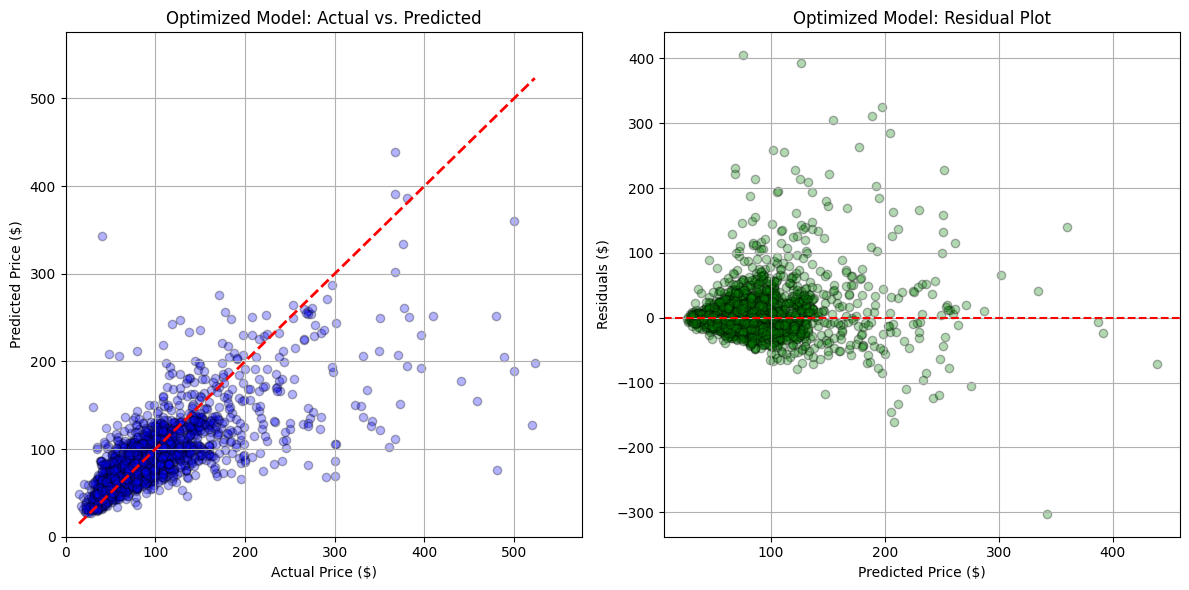

In [19]:
# Cell 8: Final Visualizations
plt.figure(figsize=(12, 6))

# Plot Actual vs. Predicted Prices
plt.subplot(1, 2, 1)
plt.scatter(y_test_true, y_test_pred, alpha=0.3, color='blue', edgecolor='k')
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], '--r', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Optimized Model: Actual vs. Predicted')
plt.grid(True)
plt.xlim([0, y_test_true.max()*1.1])
plt.ylim([0, y_test_true.max()*1.1])

# Plot Residuals
plt.subplot(1, 2, 2)
residuals = y_test_true - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.3, color='green', edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Optimized Model: Residual Plot')
plt.grid(True)

plt.tight_layout()
plt.show()
